In [1]:
import os
import jax
import html
import numpy as np
from jax import numpy as jp
import matplotlib.pyplot as plt

jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)

from IPython.display import HTML, clear_output, display
from brax.io import html

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.envs.train import Pendulum 
from src.envs.realistic import RealisticPendulum 
from functools import partial

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
# Initialize the train environment
env = Pendulum.Pendulum()

# Render an initial state of the environment
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))
HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
# Define a progress function which can be passed to either the PODS or HDS training functions
def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.plot(x_data, y_data)
    plt.show()

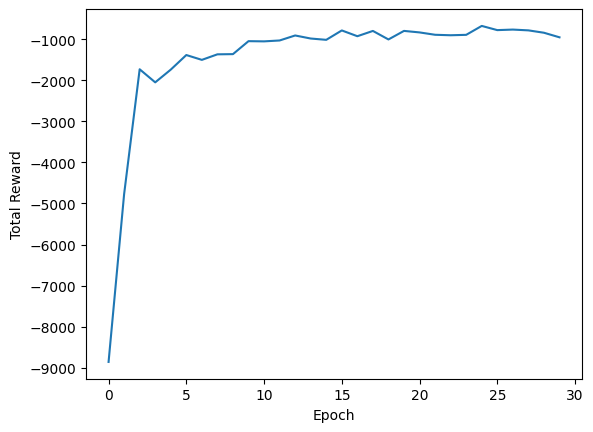

big epoch: 29 small epoch: 0 Loss 0.0005457884663688633
big epoch: 29 small epoch: 1 Loss 0.0005839078587333127
big epoch: 29 small epoch: 2 Loss 0.0019957709495262285
big epoch: 29 small epoch: 3 Loss 0.0013747134225770574
big epoch: 29 small epoch: 4 Loss 8.403418649477896e-05
big epoch: 29 small epoch: 5 Loss 0.0010433688254515602
big epoch: 29 small epoch: 6 Loss 0.00028530102453256387
big epoch: 29 small epoch: 7 Loss 0.00017899456415332662
big epoch: 29 small epoch: 8 Loss 0.00026987082680293885
big epoch: 29 small epoch: 9 Loss 0.00020775864698150816
big epoch: 29 small epoch: 10 Loss 0.00015689800695644984
big epoch: 29 small epoch: 11 Loss 0.00027261828988181606
big epoch: 29 small epoch: 12 Loss 0.0001258915257361787
big epoch: 29 small epoch: 13 Loss 0.0001480897260790151
big epoch: 29 small epoch: 14 Loss 0.0003010498402431818
big epoch: 29 small epoch: 15 Loss 7.155780236038318e-05
big epoch: 29 small epoch: 16 Loss 0.0004577337904677495
big epoch: 29 small epoch: 17 Loss 

In [5]:
policy_pods = train_pods(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a_init=2e-2, init_learning_rate=1e-3, progress_fn=progress_f)

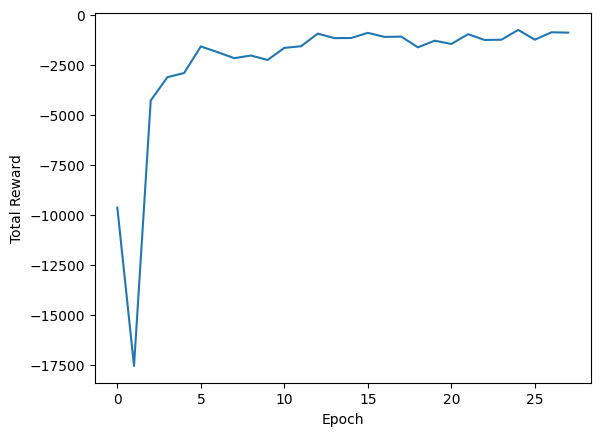

big epoch: 27 small epoch: 0 Loss 7.950889706716239e-05
big epoch: 27 small epoch: 1 Loss 0.0008747135255518882
big epoch: 27 small epoch: 2 Loss 0.0010312055927790696
big epoch: 27 small epoch: 3 Loss 6.15047116489653e-05
big epoch: 27 small epoch: 4 Loss 8.102525081119664e-05
big epoch: 27 small epoch: 5 Loss 2.1922941042360218e-05
big epoch: 27 small epoch: 6 Loss 3.488409282718418e-05
big epoch: 27 small epoch: 7 Loss 1.9445932464417713e-05
big epoch: 27 small epoch: 8 Loss 2.33738107990607e-05
big epoch: 27 small epoch: 9 Loss 1.797646509897408e-05
big epoch: 27 small epoch: 10 Loss 2.0269434136166756e-05
big epoch: 27 small epoch: 11 Loss 1.8726213797955265e-05
big epoch: 27 small epoch: 12 Loss 1.9009367969152538e-05
big epoch: 27 small epoch: 13 Loss 1.705836897768296e-05
big epoch: 27 small epoch: 14 Loss 1.792336818109192e-05
big epoch: 27 small epoch: 15 Loss 1.7015275106417175e-05
big epoch: 27 small epoch: 16 Loss 1.715357788775545e-05
big epoch: 27 small epoch: 17 Loss 1.

In [13]:
policy_hds = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a_init=2e-3, aggregation_factor_beta=0.05, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 

In [10]:
realistic_env = RealisticPendulum.RealisticPendulum()
# inference_fn_hds = policy_hds()
inference_fn_pods = policy_pods()
inference_fn_hds = policy_hds()

@partial(jax.vmap, in_axes=(None, None, None, 0), axis_name="batch")
def rollout_policy(
        env, inference_fn, trajectory_length: int, prng_keys
    ):

    def step_trajectory(state_carry, rng_key):
        action = inference_fn(state_carry.obs)
        next_state = env.step(state_carry, action)
        return next_state, (state_carry.obs, action, next_state.reward)

    state = env.reset(prng_keys)
    keys = jax.random.split(prng_keys, trajectory_length)
    _, (states, actions, rewards_future) = jax.lax.scan(
        step_trajectory, state, xs=keys
    )

    states = jax.numpy.reshape(
        states, (trajectory_length, env.observation_size)
    )
    actions = jax.numpy.reshape(
        actions, (trajectory_length, env.action_size)
    )

    totalreward = jp.sum(rewards_future)

    return states, actions, totalreward

prng_key = jax.random.PRNGKey(seed=1)
subkeys = jax.random.split(prng_key, num=50)

_, _ , rewards_original_pods  = rollout_policy(env, inference_fn_pods, 100, subkeys)
_, _ , rewards_realistic_pods = rollout_policy(realistic_env, inference_fn_pods, 100, subkeys)
# _, _ , rewards_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)
# _, _ , rewards_hds_train_env = rollout_policy(env, inference_fn_hds, 100, subkeys)

_, _ , rewards_original_hds  = rollout_policy(env, inference_fn_hds, 100, subkeys)
_, _ , rewards_realistic_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)

average_reward_original_pods = jp.mean(rewards_original_pods)
average_reward_realistic = jp.mean(rewards_realistic_pods)
average_reward_original_hds = jp.mean(rewards_original_hds)
average_reward_realistic_hds = jp.mean(rewards_realistic_hds)

# average_reward_hds = jp.mean(rewards_hds)
# average_reward_hds_train_env = jp.mean(rewards_hds_train_env)

In [11]:
print(f'PODS on real environment {jp.mean(jp.array(average_reward_realistic))}')
print(f'PODS on train environment {jp.mean(jp.array(average_reward_original_pods))}')
print(f'HDS on real environment {jp.mean(jp.array(average_reward_realistic_hds))}')
print(f'HDS on train environment {jp.mean(jp.array(average_reward_original_hds))}')
# print(f'HDS on real environment {jp.mean(jp.array(average_reward_hds))}')
# print(f'HDS on train environment {jp.mean(jp.array(average_reward_hds_train_env))}')

PODS on real environment -969.7220960760724
PODS on train environment -847.8772842825603
HDS on real environment -1150.7078841556613
HDS on train environment -1602.259872731968


In [9]:
def run_over_aggregation_factor(aggregation_factor_beta):
    policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=20, inner_epochs=20, alpha_a_init=2e-5, aggregation_factor_beta=aggregation_factor_beta,
                       init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.0, progress_fn=progress_f) 
    inference_fn = policy()
    
    prng_key = jax.random.PRNGKey(seed=0)
    subkeys = jax.random.split(prng_key, num=50)
    _, _ , rewards_hds_real_env  = rollout_policy(realistic_env, inference_fn, 100, subkeys)
    average_reward_hds_real_env = jp.mean(rewards_hds_real_env)
    print(aggregation_factor_beta)
    del policy
    del inference_fn
    return average_reward_hds_real_env

aggregation_factors = np.linspace(0.0,0.3,5)

rewards_dep_aggregation_factor = [run_over_aggregation_factor(x) for x in aggregation_factors]
rewards_pods_real_env = [average_reward_realistic for _ in aggregation_factors]
rewards_pods_train_env = [average_reward_original_pods for _ in aggregation_factors]

plt.figure(figsize=(10, 6))
clear_output(wait=True)
plt.plot(aggregation_factors, rewards_dep_aggregation_factor, label='HDS on Real Environment (Ours)', color='green')
plt.plot(aggregation_factors, rewards_pods_real_env, label='PODS on Real Environment, Mean', color='red')
plt.plot(aggregation_factors, rewards_pods_train_env, label='PODS on Train Environment, Mean', color='blue')
plt.legend()
plt.xlabel('Aggregation Factor')
plt.ylabel('Total Reward')
plt.title('Total Reward across Aggregation Factors')
plt.grid(True)
plt.show()



TypeError: train() got an unexpected keyword argument 'alpha_a'

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy_hds()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act = inference_fn(state.obs)
  reward.append(state.reward)
  state = env.step(state, act)
  actions.append(act)

print(reward, file=f)
print(actions, file=g)

In [ ]:

yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)